# Correlation and Regression Maps: Cal-Adapt
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Background: Correlation and Regression Analysis](#info)

[Load and Query the Cal-Adapt Catalog](#load)

[Read in Data](#xarray)

[Calculate Regionally Averaged Time Series](#time_series)

[Calculate Correlation or Regression Coefficients](#corr)

[Make Maps](#maps)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will continue working with the [Cal-Adapt Analytics Engine Data Catalog](https://analytics.cal-adapt.org/data/catalog/). The goal this time is to use correlation and/or regression analysis to identify the places where temperature is most highly correlated with temperature in a given location (in our case: Goleta, CA). This will be done by relating _gridpoint_ information from all locations in the Cal-Adapt domain to _time series_ information for a _regional average_ around Goleta.

Skills provided in this tutorial:
- Mapping of geospatial data;
- Regional averaging;
- Linear regression analysis;
- Correlation analysis (Pearson's R)
- Use of Python's `apply_ufunc` to apply calculations across multi-dimensional datasets

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes that you have all the packages needed for the [Plotting Regional Time Series](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb) tutorial in the EnsembleAnalysis repo installed; if you need more details on these packages, please see that tutorial.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


<a id='info'></a> 
## **Background: Correlation and Regression Analysis**

Let's start with a refresher (or introduction) to the basics of correlation and regression analysis. I'm including both of these in this tutorial for two reasons:
1) They are both extremely commonly used across climate and environmental science; and
2) From a coding perspective, their implementation is ALMOST identical (we'll see more on that below).

### **Correlation: Pearson's R**

The _correlation coefficient_, sometimes called Pearson's R, is a number that quantifies the relationship between two variables. Its value can range from -1, where the quantities are perfectly but negatively related, to +1, where the relationship is perfect and positive. In Python, there are various packages which can compute this: here we'll use the `pearsonr` function that's part of the `scipy.stats` package. That's the same package we were using in previous tutorials to calculate kernel density estimates!

### **Linear Regression**

The _regression coefficient_ is different from the correlation: it represents the _slope_ of the linear fit between two variables. There are many resources available online describing the basic principles of linear regression; we like this one:
- [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)

To perform our linear regressions today, we'll be using `scipy.stats` again, but this time a different function: it's now called `linregress`.

For both the correlation and linear regression options, the quantities we'll need are:
- the coefficient itself (either Pearson's R or regression slope), and
- the p-value associated with the correlation or linear fit.

These will be calculated not just once, but for **every single lat/lon point in your data**!

<a id='load'></a> 
## **Load and Query the Cal-Adapt Catalog**

Now we can use `intake` to load the information associated with the Cal-Adapt holdings on Amazon Web Services!

For detailed background information on Cal-Adapt, see either:
- [tutorial 1 in this repo](https://github.com/climate-datalab/Cal-Adapt-diagnostics/blob/677b41a18feb2bdd6fc2468a9aff23cc6652b781/1.%20Mapping%20Downscaled%20Products.ipynb)
- [cal-adapt.org](http://cal-adapt.org)

In [2]:
# Open the Cal-Adapt data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

Let's again build on the activities we were working on in tutorial "1. Mapping Downscaled Products" in this repository. We were using the downscaled simulations from either LOCA2 or WRF, run with the CESM2, to visualize changes in precipitation under future warming scenarios. Now let's use that same information to see how _coherent patterns_ in temperature might change in the future!

We can specify some of the necessary search terms in the catalog to extract that information:

In [3]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ["WRF"]

# experiment_id: which historical/future scenario do you want?
experiment_ids = ["historical", "ssp370"]

# table_id: which time resolution do you want?
table_id = ["day"]

# source_id: which model do you want?
source_id = ["CESM2"]

# institution_id: which research institution do you want?
institution_id = ["UCSD"]

# variable_id: which variable do you want?
variable_id = ["t2max"]

The above specifies that we would like daily information for both the historical and future (SSP3-7.0) periods from CESM2; I've also gone ahead and stated that we'll use the WRF downscaling performed at UCSD (for this particular model, there are two options which use different coordinate names - that's something we can deal with, but for simplicity we'll just use one right now).

Let's extract the catalog information for the above query, then see what variables are available to plot!

In [4]:
# Search through catalog, store results
wrf_res = catalog.search(activity_id=activity_id, experiment_id=experiment_ids,
                         table_id=table_id, source_id=source_id, 
                         institution_id=institution_id, variable_id=variable_id)

# Create a data frame
wrf_df = wrf_res.df

This query returns data associated with the `prec` variable that's the WRF version of precipitation - we learned about how to work with that in the previous tutorial.

Here I'll define a list of ensemble members: this list happens to have a length of exactly 1, since that's how many members are in this particular ensemble. In this specific case, you could do the following steps WITHOUT looping over members: I'm going to retain the loop structure so that the code will work correctly for ensembles that have larger sizes (that's good practice for making your code more functional).

In [5]:
# Define list of ensemble members
# (in this case there's only one but that might not always be true)
mems = ["r11i1p1f1"]

In [6]:
# Define an empty list
cesm2_wrf_temp = []

# Loop over all common ensemble members; leave the loop structure
# so that we can change to using multiple members if need be
for mem in range(len(mems)):
    print(mems[mem])

    # Extract HISTORICAL member of interest
    prec_cesm2df = wrf_df[(wrf_df["experiment_id"] == "historical")
                         & (wrf_df["member_id"] == mems[mem])]
    
    # Store HISTORICAL data as xarray
    hist_temp = xr.open_zarr(prec_cesm2df['path'].iloc[0], storage_options={'anon': True})

    # Do the same thing for the SSP ensemble
    prec_cesm2df = wrf_df[(wrf_df["experiment_id"] == "ssp370")
                         & (wrf_df["member_id"] == mems[mem])]    
     
    # Store SSP3-7.0 data as xarray
    ssp370_temp = xr.open_zarr(prec_cesm2df['path'].iloc[0], storage_options={'anon': True})
    
    # Concatenate historical, SSP information
    prec_data = xr.concat([hist_temp, ssp370_temp], dim="time")
    
    # Add to list
    cesm2_wrf_temp.append(prec_data)

r11i1p1f1


Now we follow our standard steps of concatenating the data into xarray objects - one for each variable - and adding the member names as values in the new "member" dimension!

In [7]:
# Concatenate the list into a single xarray object
cesm2_wrf_temp = xr.concat(cesm2_wrf_temp, dim="member")

# Store the actual member information as values of the new dimension
cesm2_wrf_temp = cesm2_wrf_temp.assign_coords(member=("member", mems))

In [8]:
cesm2_wrf_temp.lon

<xarray.DataArray 'lon' (lon: 559)>
array([-128.421875, -128.390625, -128.359375, ..., -111.046875, -111.015625,
       -110.984375])
Coordinates:
  * lon      (lon) float64 -128.4 -128.4 -128.4 -128.3 ... -111.0 -111.0 -111.0
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

<a id='time_series'></a> 
## **Calculate Regionally Averaged Time Series**

Here we need to step back a little and remember what our goal is. We're aiming to see how temperature in ONE place (Goleta, CA) is related to temperature in EVERY OTHER place (here, the rest of California). That means we have one more thing to do before we can calculate the correlation/regression maps: namely, to actually make time series for our _target region_ of Goleta. Luckily, we already know how to do this from previous tutorials!

The code block below specifies a lat/lon region and performs the regional average from the `cesm2_wrf_temp` xarray variable we already defined. (note: here I'm not going to bother with area weighting because the region is fairly small and I want to make the code more readable)

In [9]:
# Specify rough lat/lon bounds for Goleta
lat_min, lat_max = 34.2, 34.6
lon_min, lon_max = -120, -119.6

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
mask_lat = (cesm2_wrf_temp.lat >= lat_min) & (cesm2_wrf_temp.lat <= lat_max)
mask_lon = (cesm2_wrf_temp.lon >= lon_min) & (cesm2_wrf_temp.lon <= lon_max)

# Find points where the mask value is True, drop all other points
cesm2_goletatemp = cesm2_wrf_temp.where(mask_lat & mask_lon, drop=True)

# Average over the lat and lon dimensions
cesm2_goletatemp = cesm2_goletatemp.mean(dim="lat").mean(dim="lon")

Let's also go ahead and read the data into memory here, to make things run faster later on:

In [10]:
# Read time series of Goleta temperature into memory
cesm2_goletatemp = cesm2_goletatemp.compute()

In [11]:
# Read spatially varying temperature field into memory
cesm2_wrf_temp = cesm2_wrf_temp.compute()

<a id='corr'></a> 
## **Calculate Correlation or Regression Coefficients**

Now the fun part begins - we get to calculate our coefficient values! Let's define a "flag", or variable that keeps track of which type of coefficient we'd like to compute: this will let us quickly switch back and forth between regression and correlation if we change our minds about what we'd like to do later on. Here I've arbitrarily defined 0 to mean a correlation coefficient and 1 to mean a regression; you can change this to whatever you want! The only trick is to keep track of it later on when you're setting the relevant if statements (see below).

In [12]:
# Type of coefficient
# 0 = correlation, 1 = regression
coef_type = 0

### **Handling multiple dimensions: `apply_ufunc`**

If we were working with data that was just a single time series, the next part would be simple: stick the data into either the `pearsonr` or `linregress` function, look at the results, and be done with it. But climate data is more complicated than that! Instead of one dimension, we have FOUR: time, latitude, longitude, and member. That means that we need a way to make Python loop over those dimensions and deal with them appropriately!

Luckily, within xarray there's a function that does exactly what we want: `apply_ufunc`. This applies a function defined by the user, across a _dimension_ within a dataset that's also defined by the user. In this case, what we want to do is:
- apply a CORRELATION or REGRESSION function
- across the dimension of TIME

Technically, this means that we need to define our own function, that essentially says "Hello, I am a function that applies [correlation/regression] to data you give me". Here's an example of how to do this:

In [20]:
# Define correlation and regression functions

# 1) correlation
# Input data: two time series called x and y
def corr_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)
    
    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    # Output data: R, p-value for x vs y
    r, p = stats.pearsonr(x[mask], y[mask])
    
    return float(r), float(p)

# 2) regression
# Input data: two time series called x and y
def reg_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)

    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    regval = stats.linregress(x[mask], y[mask])
    return regval.slope, regval.pvalue

Now that we have both of our functions defined, we next have to apply them to our input data - then we'll have some nice maps to plot!

### **Note on correlation/regression and ensembles**

Here it's important to explain one concept that can be tricky when getting started. In our particular case we're only using ONE ensemble member. But you might have data from multiple members... and in that case, you need to be careful. 

_Rule of thumb: ALWAYS calculate correlations/regressions INDIVIDUALLY for EACH ensemble member!_

I've stated the above rule of thumb, because when you're doing a correlation or regression map, you're usually looking for a relationship between two variables **through time**. If you do something like average the ensemble members together _before_ doing the regression or correlation, you'll end up destroying the temporal relationship between your variables! That's because, as we've talked about in other tutorials, each ensemble member has a _different_ time history of climate variability: so on average, they'll end up canceling each other out!

_Other rule of thumb: It's totally fine to average correlation/regression maps AFTER you calculate them for each member!_

This may sound a little counter-intuitive, but it **is** ok to average your maps together after you make them separately for each member! That's because once you've identified the correlation/regression relationships _within_ ensemble members, they'll 

a) usually be pretty similar to each other, and
b) be _independent estimates_ of the temporal relationship between your two variables (since each ensemble member is independent of the others).

So it can actually make your statistics BETTER to average things together... as long as you do it AFTER the correlation/regression calculation!

### **Applying the correlation/regression function to data**

Let's now go ahead and actually do this thing. We'll need to loop over three of our four dimensions:
- ensemble member
- latitude
- longitude

and for each of those iterations, use `xr.apply_ufunc()` to apply our user-defined functions to the time series at that location/member.

**Note: this step can be quite slow!** 

In the code block below, I've used the `.isel` syntax to select the first ensemble member, just to make things slightly faster. If you were using this code for real on a dataset with multiple members, you can just delete the `.isel()` part of the arguments in `xr.apply_ufunc`, and the function will automatically loop over all the ensemble members!

In [ ]:
x = cesm2_goletatemp.isel(member=0).t2max.values
y = cesm2_wrf_temp.isel(member=0).t2max.values

print(corr_ts(x, y))

In [56]:
# Define output Numpy arrays to hold results
coef_vals = np.empty((len(mems), len(cesm2_wrf_temp.lat), len(cesm2_wrf_temp.lon)))
p_vals = np.empty((len(mems), len(cesm2_wrf_temp.lat), len(cesm2_wrf_temp.lon)))

# Use apply_ufunc to do the looping over lat/lon/member
if coef_type == 0:
    coef_tmp, pval_tmp = xr.apply_ufunc(corr_ts, cesm2_goletatemp.isel(member=0).t2max, 
                                        cesm2_wrf_temp.isel(member=0).t2max,  
        input_core_dims=[['time'], ['time']], output_core_dims=[[], []],
        vectorize=True, output_dtypes=[float, float]
    )    
elif coef_type == 1:
    coef_tmp, pval_tmp = xr.apply_ufunc(reg_ts, cesm2_goletatemp.isel(member=0).t2max, 
                                        cesm2_wrf_temp.isel(member=0).isel(member=0).t2max,  
        input_core_dims=[['time'], ['time']], output_core_dims=[[], []],
        vectorize=True, output_dtypes=[float, float]
    )    

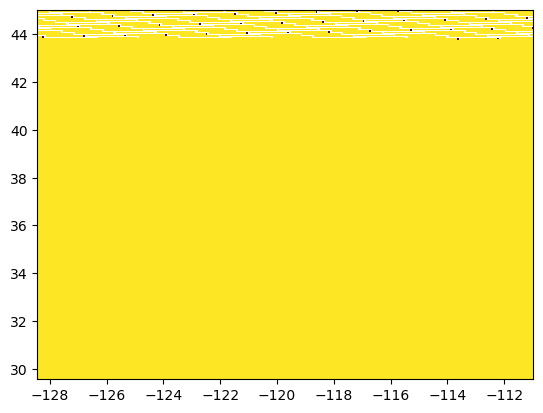

In [57]:
plt.pcolor(cesm2_wrf_temp.lon, cesm2_wrf_temp.lat,coef_vals.squeeze())

<a id='maps'></a> 
## **Make Maps**

Now that we've done all the hard parts, it's time to finally plot the results! We'll just use the output from the previous code blocks and lay them onto our map of California, similar to what was done in previous tutorials in this repo.

As a nice bonus, we'll ALSO add code to stipple (plot dots where) the locations where the significance levels are above 90%!

The below code block plots results for the correlation coefficient option - if you'd like to use the regression coefficients, just change the appropriate plot labels to match.

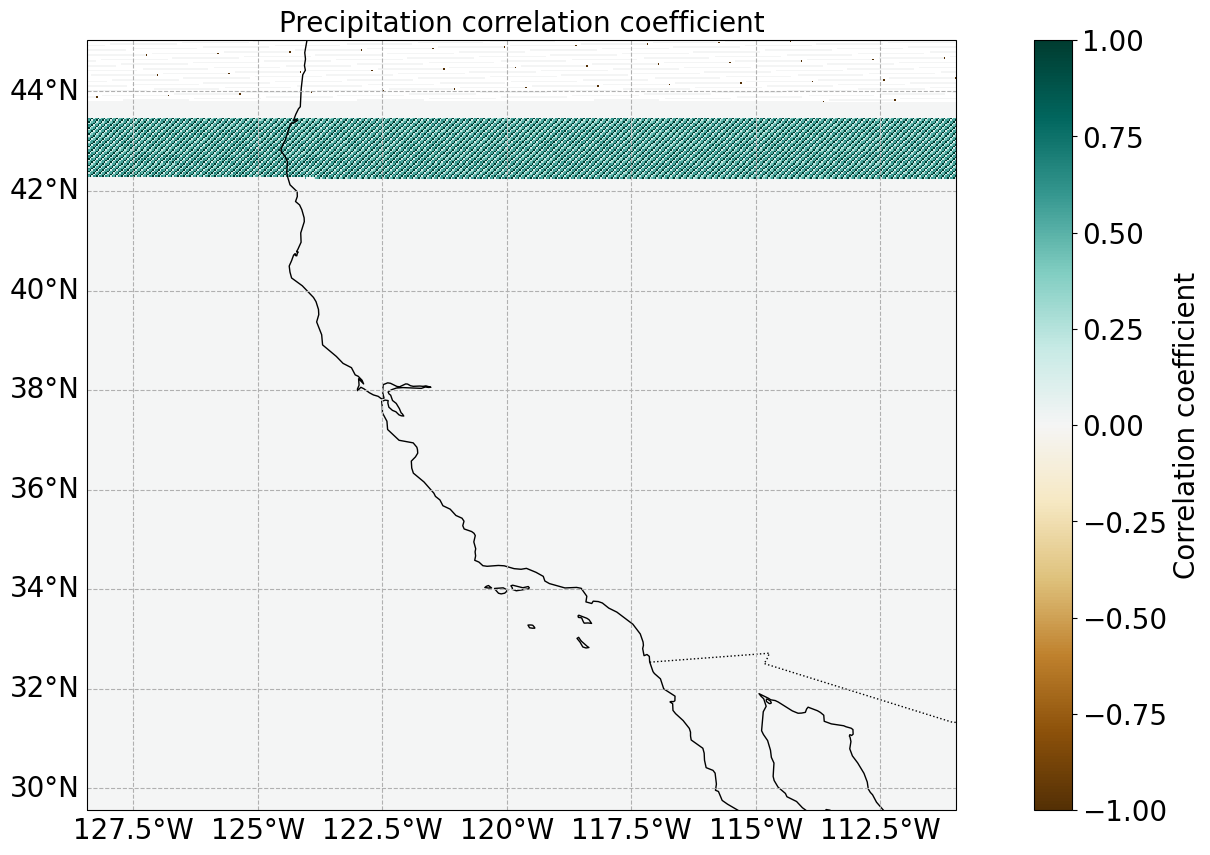

In [58]:
# Plot the results!
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot data onto those axes
plot = ax.pcolormesh(cesm2_wrf_temp.lon, cesm2_wrf_temp.lat, coef_vals.squeeze(), 
                     transform=map, cmap="BrBG", vmin=-1, vmax=1, shading='auto')
# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Correlation coefficient", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Statistical significance for historical vs future precip change regressed on gradient change
#latitudes, longitudes = np.where(pval_tmp < 0.05)
#lats = cesm2_wrf_temp.coords['lat'][latitudes].values
#lons = cesm2_wrf_temp.coords['lon'][longitudes].values
#ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Precipitation correlation coefficient", fontsize= 20)
plt.show()